### Additive Regression 
$$f_c \sim \cal{GP}(0,k_c),\; \forall c \in [1..C]$$
$$y^{(n)}|f_1...f_C,x^{(n)} = y^{(n)}|\sum_c f_c(x^{(n)}_c)$$

Functions $f_c$ are all functions of separate covariates $x_c$


### Mean Field Posterior

$$ p(f_1,...f_C|X,Y)=\prod_c p(f_c|u_c)q(u_c)$$

In [1]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.contrib.opt import ScipyOptimizerInterface as soi
np.random.seed(10)

## Simulating synthetic data

In [2]:
lik = 'Poisson'
lik = 'Gaussian'
assert lik in ['Poisson','Gaussian']

#---------------------------------------------------
# Declaring additive model parameters
N =500
D = 3 # number of covariates 
R = 1 # number of trials
fs = [lambda x:np.sin(x)**3, lambda x:np.cos(3.*x), lambda x:x]
f_indices = [[d] for d in range(D)]
C = len(f_indices) # number of additive terms
#---------------------------------------------------
# Simulating data
np_link,tf_link = np.exp, tf.exp

xmin,xmax=-3,3
X_np = np.random.uniform(xmin,xmax,(N,D))
F_np = np.hstack([fs[d](X_np[:,f_indices[d]]) for d in range(D)])
pred_np = np.sum(F_np,axis=1,keepdims=True)
Y_np = pred_np + np.random.randn(N,R)*.1

if lik == 'Gaussian':
    Y_np = pred_np + np.random.randn(N,R)*.5
elif lik=='Poisson':
    link = np.exp
    rate = np.tile(link(pred_np),[1,R])
    Y_np = np.random.poisson(rate,size=(N,R))


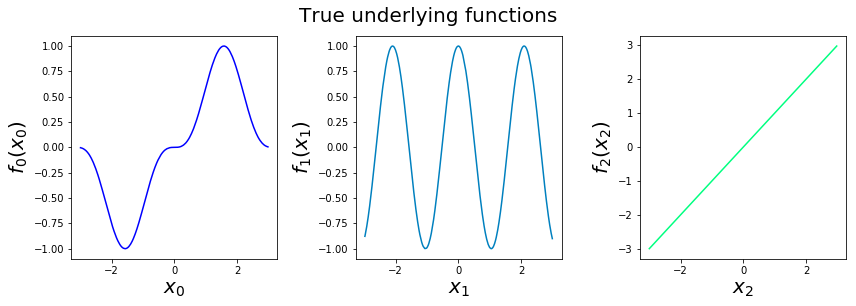

In [3]:
colors_c = plt.cm.winter(np.linspace(0,1,C))
fig,ax = plt.subplots(1,C,figsize=(C*4,4))
for c in range(C):
    i = f_indices[c]
    if len(f_indices[c])==1:
        o = np.argsort(X_np[:,f_indices[c]],0)
        ax[c].plot(X_np[o,i],F_np[o,c],'-',color=colors_c[c])
        ax[c].set_xlabel('$x_%d$'%i[0],fontsize=20)
        ax[c].set_ylabel('$f_%d(x_%d)$'%(i[0],i[0]),fontsize=20)
    elif len(f_indices[c])==2:
        ax[c].scatter(X_np[:,i[0]],
                      X_np[:,i[1]],
                      c=F_np[:,c],linewidth=0)
        ax[c].set_xlabel('$x_%d$'%i[0],fontsize=20)
        ax[c].set_ylabel('$x_%d$'%i[1],fontsize=20)
        ax[c].set_title('$f(x_%d,x_%d)$'%(i[0],i[1]),fontsize=20)
plt.suptitle('True underlying functions',y=1.05,fontsize=20)   
fig.tight_layout()
plt.show()


## Constructing tensorflow model

In [4]:
import sys
sys.path.append('../SVGPs')
from kernels import RBF
from likelihoods import Gaussian, Poisson, Gaussian_with_link
from settings import np_float_type,int_type
from model import SVAGP_DS

#---------------------------------------------------
# Constructing tensorflow model

X = tf.placeholder(tf.float32,[N,D])
Y = tf.placeholder(tf.float32,[N,R])
ks,Zs = [],[]

ks =[]
with tf.variable_scope("kernels") as scope:
    for c in range(C):
        with tf.variable_scope("kernel%d"%c) as scope:
            input_dim = len(f_indices[c])
            ks.append(  RBF(input_dim,lengthscales=.5*np.ones(input_dim),  variance=1.))    
    
with tf.variable_scope("likelihood") as scope:
    if lik=='Gaussian':
        likelihood = Gaussian(variance=1)
    elif lik == 'Poisson':
        likelihood = Poisson()
    
with tf.variable_scope("ind_points") as scope:
    for c in range(C):
        with tf.variable_scope("ind_points%d"%c) as scope:
            input_dim = len(f_indices[c])
            Z_ = np.random.uniform(xmin,xmax,[10,input_dim]).astype(np_float_type)
            Zs.append(   tf.Variable(Z_,tf.float32,name='Z') )


with tf.variable_scope("model") as scope:
    m= SVAGP_DS(X,Y,ks,likelihood,Zs,q_diag=True,f_indices=f_indices,n_samp=10)

    
    

## Running inference and learning

In [5]:

#---------------------------------------------------

sess  = tf.Session()
sess.run(tf.global_variables_initializer()) # reset values to wrong
# declare loss
loss = -m.build_likelihood()
opt_global = tf.train.AdamOptimizer(1e-3).minimize(loss)

init = tf.global_variables_initializer()
sess.run(init) # reset values to wrong
feed_dic = {Y:Y_np, X:X_np}

#---------------------------------------------------


print('Running Optimization...')
nit = 8000
loss_array = np.zeros((nit,))

for it in tqdm(range( nit)):
    sess.run(opt_global,feed_dict=feed_dic)
    loss_array[it]= float(sess.run(loss, feed_dic))


# declare which optimization to perform


Fs_mean,Fs_var = sess.run(m.build_predict_fs(X),  feed_dic)
pred_samples = m.sample_predictor(X)
pred_mean= sess.run(tf.reduce_mean(pred_samples,axis=-1) ,feed_dic)
Zs = sess.run(m.Zs,  feed_dic)

sess.close()

print('Done')


  0%|          | 1/8000 [00:00<24:36,  5.42it/s]

Running Optimization...


100%|██████████| 8000/8000 [01:12<00:00, 110.37it/s]


Done


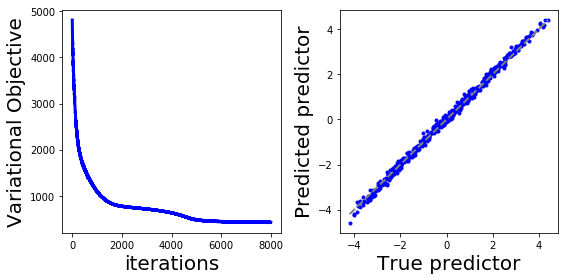

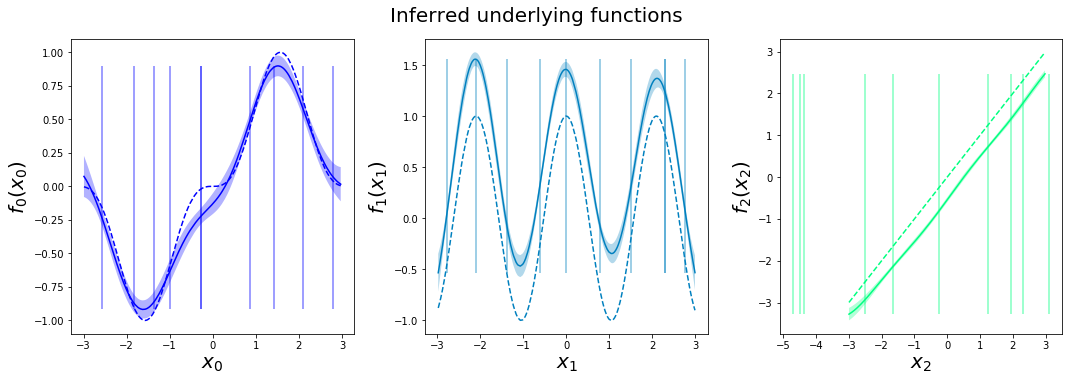

In [6]:
fig,axarr = plt.subplots(1,2,figsize=(8,4))
ax=axarr[0]
ax.plot(loss_array[:it], linewidth=3, color='blue')
ax.set_xlabel('iterations',fontsize=20)
ax.set_ylabel('Variational Objective',fontsize=20)
ax=axarr[1]
ax.plot(pred_mean,pred_np,'.',color='blue')
ax.plot([pred_mean.min(),pred_mean.max()],
        [pred_mean.min(),pred_mean.max()],
        '--',linewidth=2,color='grey')
ax.set_xlabel('True predictor',fontsize=20)
ax.set_ylabel('Predicted predictor',fontsize=20)
fig.tight_layout()
plt.show()
plt.close()


fig,ax = plt.subplots(1,C,figsize=(C*5,5))
for c in range(C):
    i = f_indices[c]
    if len(i)==1:
        o = np.argsort(X_np[:,i],0)
        f,s =  Fs_mean[c,:,0],np.sqrt(Fs_var[c,:,0])
        ax[c].vlines(Zs[c],ymin=f.min(),ymax=f.max(),alpha=.5,color=colors_c[c])
        ax[c].plot(X_np[o,i],f[o],color=colors_c[c])
        ax[c].fill_between(X_np[o,i].flatten(),
                           (f-s)[o].flatten(),
                           y2=(f+s)[o].flatten(),
                           alpha=.3,facecolor=colors_c[c])
        ax[c].plot(X_np[o,i],F_np[o,c],'--',color=colors_c[c])
        ax[c].set_xlabel('$x_%d$'%i[0],fontsize=20)
        ax[c].set_ylabel('$f_%d(x_%d)$'%(i[0],i[0]),fontsize=20)

    elif len(f_indices[c])==2:
        ax[c].scatter(X_np[:,i[0]],
                      X_np[:,i[1]],
                      c=Fs_mean[c,:,0],linewidth=0)
        ax[c].scatter(Zs[c][:,0],Zs[c][:,1],
                      c='r', marker=(5, 1))
        ax[c].set_xlabel('$x_%d$'%i[0],fontsize=20)
        ax[c].set_ylabel('$x_%d$'%i[1],fontsize=20)
        ax[c].set_title('$f(x_%d,x_%d)$'%(i[0],i[1]),fontsize=20)
plt.suptitle('Inferred underlying functions',y=1.05,fontsize=20) 
fig.tight_layout()

plt.show()